In [1]:
import glob 
import numpy as np 
import os 
import shutil 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model 
#from keras.applications.inception_resnet_v2 import preprocess_input
import keras 
import matplotlib.pyplot as plt 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential 
from keras import optimizers  

In [2]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        

In [3]:
IM_SHAPE=(224,224)
input_shape=(IM_SHAPE[0],IM_SHAPE[1],3)

In [4]:
batch_size = 32
num_classes = 2 
epochs = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=preprocess_input,
                                      validation_split=0.3)
val_datagen=ImageDataGenerator(rescale=1./255,
                               preprocessing_function=preprocess_input,
                                      validation_split=0.2)

# train_generator = train_datagen.flow_from_directory(
#     '../input/covidog/dataset',
#     target_size=IM_SHAPE,

#     batch_size=batch_size,
#     class_mode='categorical') # set as training data

train_generator_NEW = train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train', # same directory as training data
    target_size=IM_SHAPE,
    subset='training',
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
validation_generator_NEW= train_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Train',
#     batch_size=16,
    subset='validation',
    class_mode='categorical',
    target_size=IM_SHAPE
)
test_generator_NEW=val_datagen.flow_from_directory(
    '/kaggle/input/covidnew/ALL/Test',
    #batch_size=16,
    class_mode='categorical',
    target_size=IM_SHAPE
)

Found 14461 images belonging to 2 classes.
Found 6196 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [5]:
#from keras.applications import DenseNet121

from keras.applications import resnet_v2
vgg =  resnet_v2.ResNet50V2(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = vgg.layers[-1].output 
output = keras.layers.Flatten()(output) 
vgg_model = Model(vgg.input, output) 
vgg_model.trainable = False 
 
for layer in vgg_model.layers: 
    layer.trainable = False 

#vgg_model.summary()

2023-02-01 06:20:12.907447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 06:20:12.994741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 06:20:12.995560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 06:20:12.997470: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 3s 0us/step


In [6]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           vgg_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  This is separate from the ipykernel package so we can avoid doing imports until


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7f23c4559ad0>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7f242497b9d0>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7f23c4299d90>,conv1_conv,False
3,<keras.layers.convolutional.ZeroPadding2D object at 0x7f23c21d45d0>,pool1_pad,False
4,<keras.layers.pooling.MaxPooling2D object at 0x7f23c21099d0>,pool1_pool,False
...,...,...,...
186,<keras.layers.convolutional.Conv2D object at 0x7f23c14d5a50>,conv5_block3_3_conv,False
187,<keras.layers.merge.Add object at 0x7f23c1568990>,conv5_block3_out,False
188,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f23c2115a90>,post_bn,False
189,<keras.layers.core.Activation object at 0x7f23c154e950>,post_relu,False


In [7]:
print("Trainable layers:", vgg_model.trainable_weights)


Trainable layers: []


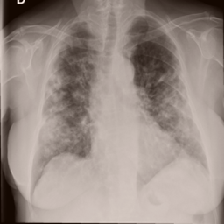

In [8]:
array_to_img(train_generator_NEW[0][0][0])

2023-02-01 06:20:21.280769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-01 06:20:22.888139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(32, 7, 7, 2048)


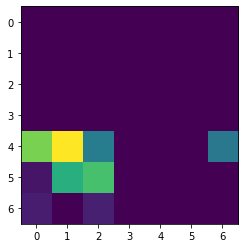

In [9]:
bottleneck_feature_example = vgg.predict(train_generator_NEW[0][0])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [10]:
model_TF = Sequential() 

model_TF.add(vgg_model) 
# model_TF.add(Dense(1024, activation='relu')) 
# model_TF.add(Dropout(0.25)) 
# model_TF.add(Dense(512, activation='relu')) 
# model_TF.add(Dropout(0.25))
# model_TF.add(Dense(256, activation='relu')) 
model_TF.add(Dropout(0.25))
model_TF.add(Dense(num_classes, activation='sigmoid'))

model_TF.summary()

model_TF.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23564800  
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 200706    
Total params: 23,765,506
Trainable params: 200,706
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# history_TF = model_TF.fit(train_generator_NEW, 
#                               epochs=15,  
#                               validation_data=validation_generator_NEW,  
#                               verbose=1)

In [12]:
history_TF = model_TF.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


452/452 [==============================] - 206s 449ms/step - loss: 5.3508 - accuracy: 0.8855 - f1_m: 0.8846 - precision_m: 0.8873 - recall_m: 0.8821 - val_loss: 3.5834 - val_accuracy: 0.9211 - val_f1_m: 0.9212 - val_precision_m: 0.9233 - val_recall_m: 0.9192
Epoch 2/15
452/452 [==============================] - 73s 162ms/step - loss: 2.9194 - accuracy: 0.9320 - f1_m: 0.9317 - precision_m: 0.9332 - recall_m: 0.9302 - val_loss: 1.8109 - val_accuracy: 0.9572 - val_f1_m: 0.9571 - val_precision_m: 0.9591 - val_recall_m: 0.9552
Epoch 3/15
452/452 [==============================] - 74s 163ms/step - loss: 2.2186 - accuracy: 0.9454 - f1_m: 0.9450 - precision_m: 0.9469 - recall_m: 0.9432 - val_loss: 3.2696 - val_accuracy: 0.9375 - val_f1_m: 0.9374 - val_precision_m: 0.9389 - val_recall_m: 0.9360
Epoch 4/15
452/452 [==============================] - 75s 167ms/step - loss: 1.6622 - accuracy: 0.9558 - f1_m: 0.9561 - precision_m: 0.9578 - recall_m: 0.9545 - val_loss: 2.2437 - val_accuracy: 0.9524 - 

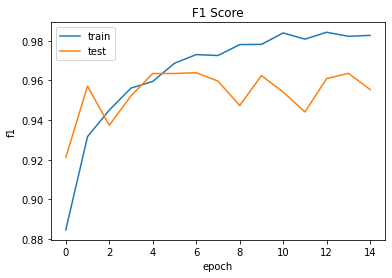

In [13]:
plt.plot(history_TF.history['f1_m'])
plt.plot(history_TF.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
test_loss= model_TF.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 19s 303ms/step - loss: 2.6224 - accuracy: 0.9515 - f1_m: 0.9515 - precision_m: 0.9537 - recall_m: 0.9494


In [15]:
test_loss

[2.6224310398101807,
 0.9514999985694885,
 0.9515227675437927,
 0.9537089467048645,
 0.949404776096344]

In [16]:
from keras.applications import resnet_v2
dense =  resnet_v2.ResNet50V2(include_top=False,  
                                     input_shape=input_shape) 
output = dense.layers[-1].output 
output = keras.layers.Flatten()(output) 
dense_model = Model(dense.input, output) 
dense_model.trainable = True
dense_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [17]:
model = Sequential() 

model.add(dense_model) 
# model.add(Dense(1024, activation='relu')) 
# model.add(Dropout(0.25)) 
# model.add(Dense(512, activation='relu')) 
# model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu')) 
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='sigmoid'))



model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      metrics=['accuracy',f1_m,precision_m, recall_m])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100352)            23564800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 200706    
Total params: 23,765,506
Trainable params: 23,720,066
Non-trainable params: 45,440
_________________________________________________________________


In [19]:
history = model.fit(train_generator_NEW, 
                              epochs=15,  
                              validation_data=validation_generator_NEW,  
                              verbose=1)

Epoch 1/15
452/452 [==============================] - 102s 213ms/step - loss: 0.3154 - accuracy: 0.9314 - f1_m: 0.9303 - precision_m: 0.9289 - recall_m: 0.9321 - val_loss: 0.1015 - val_accuracy: 0.9714 - val_f1_m: 0.9716 - val_precision_m: 0.9695 - val_recall_m: 0.9737
Epoch 2/15
452/452 [==============================] - 96s 212ms/step - loss: 0.0466 - accuracy: 0.9829 - f1_m: 0.9832 - precision_m: 0.9819 - recall_m: 0.9846 - val_loss: 0.1041 - val_accuracy: 0.9718 - val_f1_m: 0.9723 - val_precision_m: 0.9725 - val_recall_m: 0.9721
Epoch 3/15
452/452 [==============================] - 96s 213ms/step - loss: 0.0215 - accuracy: 0.9923 - f1_m: 0.9917 - precision_m: 0.9908 - recall_m: 0.9926 - val_loss: 0.0703 - val_accuracy: 0.9853 - val_f1_m: 0.9854 - val_precision_m: 0.9850 - val_recall_m: 0.9859
Epoch 4/15
452/452 [==============================] - 96s 211ms/step - loss: 0.0122 - accuracy: 0.9962 - f1_m: 0.9959 - precision_m: 0.9958 - recall_m: 0.9960 - val_loss: 0.0824 - val_accuracy

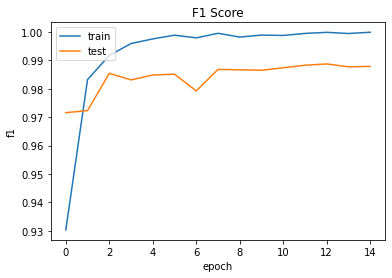

In [20]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
test_loss= model.evaluate(test_generator_NEW, verbose=1)

63/63 [==============================] - 7s 115ms/step - loss: 0.0550 - accuracy: 0.9880 - f1_m: 0.9871 - precision_m: 0.9867 - recall_m: 0.9876


In [22]:
test_loss

[0.054990045726299286,
 0.9879999756813049,
 0.9871024489402771,
 0.9866502285003662,
 0.9875991940498352]